In [3]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
!rm -rf drift-lens

In [5]:
# Clone the repo directly
!git clone https://github.com/grecosalvatore/drift-lens.git

Cloning into 'drift-lens'...
remote: Enumerating objects: 1632, done.
remote: Counting objects: 100% (340/340), done.
remote: Compressing objects: 100% (200/200), done.
remote: Total 1632 (delta 255), reused 213 (delta 140), pack-reused 1292 (from 2)
Receiving objects: 100% (1632/1632), 17.78 MiB | 18.25 MiB/s, done.
Resolving deltas: 100% (1192/1192), done.


In [6]:
# !python /content/drift-lens/setup.py egg_info
# !python --version
!pip install -e ./drift-lens
# !pip install driftlens

Obtaining file:///content/drift-lens
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 59.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.3/57.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 816.5/816.5 kB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 8.8 MB/s eta 0:00:00
  Created wheel for matplotlib: filename=matplotlib-3.5.3-cp311-cp311-linux_x86_64.whl size=11116956 sha256=df97a72b678cbb961c8c50df1156be2ec425214bfc9caaac7e07a15d3f44ec18
  Stored in directory: /root/.cache/pip/wheels/5d/3b/87/b850f835f7a97bd28b0fb81fd73bdb17755122ea5ad71484f9
Successfully built matplotlib
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.67.1
    Uninstalling tqdm-4.67.1:
      Successfully uninstalled tqdm-4.67.1
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.2.0
    Uninstalling s

In [1]:
!pip install alibi-detect

  Using cached alibi_detect-0.12.0-py3-none-any.whl.metadata (28 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached pillow-10.4.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (9.2 kB)
  Using cached scikit_image-0.22.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
  Using cached numba-0.59.1-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (2.7 kB)
  Using cached llvmlite-0.42.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.8 kB)
Using cached alibi_detect-0.12.0-py3-none-any.whl (381 kB)
Using cached numba-0.59.1-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (3.7 MB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
Using cached pillow-10.4.0-cp311-cp311-manylinux_2_28_x86_64.whl (4.5 MB)
Using cached scikit_image-0.22.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (14.

In [2]:
!find /content/drift-lens/experiments -type d -name "windows_manager"


/content/drift-lens/experiments/windows_manager


In [1]:
import argparse
from alibi_detect.cd import KSDrift, MMDDrift, LSDDDrift, CVMDrift, ChiSquareDrift
import sys
sys.path.append('/content/drift-lens')
from experiments.windows_manager.windows_generator import WindowsGenerator
from driftlens.driftlens import DriftLens
import os
import h5py
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import numpy as np
import json
import datetime
import time
import torch
import statistics
import os

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [2]:
path = '/content/drive/MyDrive/drift-guard/fashion-mnist-use-case/saved_embeddings'

# join path with embedding files
path_train = os.path.join(path, 'Conv_VGG-16_FNIST_train.hdf5')
path_test = os.path.join(path, 'Conv_VGG-16_FNIST_test.hdf5')
path_new = os.path.join(path, 'Conv_VGG-16_FNIST_new.hdf5') # unseen data
path_deg = os.path.join(path, 'Conv_VGG-16_FNIST_deg.hdf5')

output_dir = '/content/drive/MyDrive/drift-guard/fashion-mnist-use-case/results/'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Directory created: {output_dir}")
else:
    print(f"Directory already exists: {output_dir}")

Directory already exists: /content/drive/MyDrive/drift-guard/fashion-mnist-use-case/results/


In [7]:
def parse_args():
    class Args:
        number_of_runs = 5
        model_name = "vgg16"
        window_size = 1000
        number_of_windows = 100
        drift_percentage = [0, 5, 10, 15, 20]
        batch_n_pc = 150
        per_label_n_pc = 75
        threshold_sensitivity = 0.01
        threshold_number_of_estimation_samples = 1000
        n_subsamples_mmd = 1000
        n_subsamples_lsdd = 1000
        n_subsamples_cvm = 1000
        n_subsamples_ks = 1000
        run_driftlens = True
        train_embedding_filepath = path_train
        test_embedding_filepath = path_test
        new_unseen_embedding_filepath = path_new
        drift_embedding_filepath = path_deg
        output_dir = output_dir
        save_results = True
        cuda = False
        verbose = False
        seed = 42

    return Args()

In [ ]:
# def load_embedding(filepath, E_name=None, Y_original_name=None, Y_predicted_name=None):
#     if filepath is not None:
#         with h5py.File(filepath, "r") as hf:
#             if E_name is None:
#                 E = hf["E"][()]
#             else:
#                 E = hf[E_name][()]
#             if Y_original_name is None:
#                 Y_original = hf["Y_original"][()]
#             else:
#                 Y_original = hf[Y_original_name][()]
#             if Y_predicted_name is None:
#                 Y_predicted = hf["Y_predicted"][()]
#             else:
#                 Y_predicted = hf[Y_predicted_name][()]
#     else:
#         raise Exception("Error in loading the embedding file. Please set the embedding paths in the configuration file.")
#     return E, Y_original, Y_predicted


# def stratified_subsampling(E, Y, n_samples, unique_labels):
#     # Calculate samples per class
#     samples_per_class = int(n_samples / len(unique_labels))

#     # Placeholder for stratified sample indices
#     selected_indices = []

#     for label in unique_labels:
#         # Find indices where current label occurs
#         label_indices = np.where(Y == label)[0]

#         # If the class has fewer samples than samples_per_class, take them all
#         # Otherwise, randomly choose samples_per_class from them
#         if len(label_indices) <= samples_per_class:
#             selected_indices.extend(label_indices)
#         else:
#             selected_indices.extend(np.random.choice(label_indices, samples_per_class, replace=False))

#     # Now, selected_indices contains the indices of the stratified sample
#     # Extract the corresponding elements from E
#     E_subsample = E[selected_indices]

#     return E_subsample, Y[selected_indices]


# def main():
#     print("Drift Detection Experiment - Use Case - Fashion MNIST")

#     # Parse arguments
#     args = parse_args()

#     print("Model name: ", args.model_name)
#     print("Number of runs: ", args.number_of_runs)
#     print("Window size: ", args.window_size)
#     print("Number of windows: ", args.number_of_windows)
#     print("Number of window reference samples : ", args.n_subsamples_mmd)
#     print("Number of window reference samples : ", args.n_subsamples_lsdd)
#     print("Number of window reference samples : ", args.n_subsamples_cvm)
#     print("Number of window reference samples : ", args.n_subsamples_ks)
#     print("Number of samples threshold: ", args.threshold_number_of_estimation_samples)
#     print("Drift percentage: ", args.drift_percentage)

#     training_label_list = [0, 1, 2, 3, 4, 5, 6, 7]  # Labels used for training
#     drift_label_list = [8]  # Labels used for drift simulation

#     if args.save_results:
#         if not os.path.exists(args.output_dir):
#             os.makedirs(args.output_dir)
#         ts = time.time()
#         timestamp = str(datetime.datetime.fromtimestamp(ts).strftime('%Y%m%d_%H%M%S'))
#         output_filename = f"drift_detection_accuracy_model_{args.model_name}_win_size_{args.window_size}_n_windows_{args.number_of_windows}_{timestamp}.json"

#     # Parse parameters
#     window_size = args.window_size
#     batch_n_pc = args.batch_n_pc
#     per_label_n_pc = args.per_label_n_pc
#     n_windows = args.number_of_windows

#     # Load the embeddings
#     if args.model_name == "vgg16":
#         #E_train, Y_original_train, Y_predicted_train = load_embedding(args.train_embedding_filepath, E_name="E", Y_original_name="original_label", Y_predicted_name="predicted_label")
#         #E_test, Y_original_test, Y_predicted_test = load_embedding(args.test_embedding_filepath, E_name="E", Y_original_name="original_label", Y_predicted_name="predicted_label")
#         #E_new_unseen, Y_original_new_unseen, Y_predicted_new_unseen = load_embedding(args.new_unseen_embedding_filepath, E_name="E", Y_original_name="original_label", Y_predicted_name="predicted_label")
#         #E_drift, Y_original_drift, Y_predicted_drift = load_embedding(args.drift_embedding_filepath, E_name="E", Y_original_name="original_label", Y_predicted_name="predicted_label")
#         E_train, Y_original_train, Y_predicted_train = load_embedding(args.train_embedding_filepath)
#         E_test, Y_original_test, Y_predicted_test = load_embedding(args.test_embedding_filepath)
#         E_new_unseen, Y_original_new_unseen, Y_predicted_new_unseen = load_embedding(args.new_unseen_embedding_filepath)
#         E_drift, Y_original_drift, Y_predicted_drift = load_embedding(args.drift_embedding_filepath)

#         E_train = E_train.reshape(E_train.shape[0], -1)
#         E_test = E_test.reshape(E_test.shape[0], -1)
#         E_new_unseen = E_new_unseen.reshape(E_new_unseen.shape[0], -1)
#         E_drift = E_drift.reshape(E_drift.shape[0], -1)

#     else:
#         E_train, Y_original_train, Y_predicted_train = load_embedding(args.train_embedding_filepath)
#         E_test, Y_original_test, Y_predicted_test = load_embedding(args.test_embedding_filepath)
#         E_new_unseen, Y_original_new_unseen, Y_predicted_new_unseen = load_embedding(args.new_unseen_embedding_filepath)
#         E_drift, Y_original_drift, Y_predicted_drift = load_embedding(args.drift_embedding_filepath)

#     print("Input shape", E_train.shape)

#     print("Training samples:", len(E_train))
#     print("Test samples:", len(E_test))
#     print("New unseen samples:", len(E_new_unseen))
#     print("Drift samples:", len(E_drift))


#     ks_acc_dict = {str(p): [] for p in args.drift_percentage}
#     mmd_acc_dict = {str(p): [] for p in args.drift_percentage}
#     lsdd_acc_dict = {str(p): [] for p in args.drift_percentage}
#     cvm_acc_dict = {str(p): [] for p in args.drift_percentage}
#     driftlens_acc_dict = {str(p): [] for p in args.drift_percentage}

#     output_dict_run_list = []

#     output_dict = {"params": vars(args)}

#     for run_id in range(args.number_of_runs):

#         print(f"\nRun {run_id + 1}/{args.number_of_runs}")

#         # Initialize the WindowsGenerator - used for creating the windows
#         wg = WindowsGenerator(training_label_list,
#                               drift_label_list,
#                               E_new_unseen,
#                               Y_predicted_new_unseen,
#                               Y_original_new_unseen,
#                               E_drift,
#                               Y_predicted_drift,
#                               Y_original_drift)

#         if args.run_driftlens:
#             # Initialize the DriftLens
#             dl = DriftLens()

#             # Estimate the baseline with DriftLens
#             baseline = dl.estimate_baseline(E=E_train,
#                                             Y=Y_predicted_train,
#                                             label_list=training_label_list,
#                                             batch_n_pc=batch_n_pc,
#                                             per_label_n_pc=per_label_n_pc)

#             # Estimate the threshold values with DriftLens
#             per_batch_distances_sorted, per_label_distances_sorted = dl.random_sampling_threshold_estimation(
#                 label_list=training_label_list,
#                 E=E_test,
#                 Y=Y_predicted_test,
#                 batch_n_pc=batch_n_pc,
#                 per_label_n_pc=per_label_n_pc,
#                 window_size=window_size,
#                 n_samples=args.threshold_number_of_estimation_samples,
#                 flag_shuffle=True,
#                 flag_replacement=True)

#             # Calculate the threshold values
#             l = np.array(per_batch_distances_sorted)
#             l = l[(l > np.quantile(l, 0.01)) & (l < np.quantile(l, 0.99))].tolist()
#             per_batch_th = max(l)
#         else:
#             print("DriftLens skipped")

#         if (args.n_subsamples_mmd < len(E_train)) and (args.n_subsamples_mmd != -1):

#             E_subsample_mmd, Y_subsample_mmd = stratified_subsampling(E_train,
#                                                               Y_original_train,
#                                                               n_samples=args.n_subsamples_mmd,
#                                                               unique_labels=training_label_list)
#         else:
#             E_subsample_mmd, Y_subsample_mmd = (E_train, Y_original_train)

#         if (args.n_subsamples_lsdd < len(E_train)) and (args.n_subsamples_lsdd != -1):

#             E_subsample_lsdd, Y_subsample_lsdd = stratified_subsampling(E_train,
#                                                               Y_original_train,
#                                                               n_samples=args.n_subsamples_lsdd,
#                                                               unique_labels=training_label_list)
#         else:
#             E_subsample_lsdd, Y_subsample_lsdd = (E_train, Y_original_train)

#         if (args.n_subsamples_cvm < len(E_train)) and (args.n_subsamples_cvm != -1):

#             E_subsample_cvm, Y_subsample_cvm = stratified_subsampling(E_train,
#                                                               Y_original_train,
#                                                               n_samples=args.n_subsamples_cvm,
#                                                               unique_labels=training_label_list)
#         else:
#             E_subsample_cvm, Y_subsample_cvm = (E_train, Y_original_train)

#         if (args.n_subsamples_ks < len(E_train)) and (args.n_subsamples_ks != -1):

#             E_subsample_ks, Y_subsample_ks = stratified_subsampling(E_train,
#                                                               Y_original_train,
#                                                               n_samples=args.n_subsamples_ks,
#                                                               unique_labels=training_label_list)
#         else:
#             E_subsample_ks = E_train
#             Y_subsample_ks = Y_original_train

#         print(f"MMD reference window size: {E_subsample_mmd.shape[0]}")
#         print(f"LSDD reference window size: {E_subsample_lsdd.shape[0]}")
#         print(f"CVM reference window size: {E_subsample_cvm.shape[0]}")
#         print(f"KS reference window size: {E_subsample_ks.shape[0]}")

#         # Initialize drift detectors used for comparison
#         ks_detector = KSDrift(E_subsample_ks, p_val=.05)
#         mmd_detector = MMDDrift(E_subsample_mmd, p_val=.05, n_permutations=100, backend="pytorch")
#         lsdd_detector = LSDDDrift(E_subsample_lsdd, backend='pytorch', p_val=.05)
#         cvm_detector = CVMDrift(E_subsample_cvm, p_val=.05)

#         for current_drift_percentage in args.drift_percentage:

#             print(f" Drift percentage: {current_drift_percentage}")

#             # Initialize empty lists of predictions
#             ks_preds = []
#             mmd_preds = []
#             lsdd_preds = []
#             cvm_preds = []
#             dl_distances = []

#             # Ground truth
#             if current_drift_percentage > 0:
#                 ground_truth = [1] * n_windows
#             else:
#                 ground_truth = [0] * n_windows

#             # Generate windows and predict drift
#             for i in tqdm(range(n_windows)):

#                 if current_drift_percentage > 0:
#                     # Drift
#                     E_windows, Y_predicted_windows, Y_original_windows = wg.balanced_constant_drift_windows_generation(window_size=window_size,
#                                                                                                                         n_windows=1,
#                                                                                                                         drift_percentage=float(current_drift_percentage/100),
#                                                                                                                         flag_shuffle=True,
#                                                                                                                         flag_replacement=True)

#                 else:
#                     # No Drift
#                     E_windows, Y_predicted_windows, Y_original_windows = wg.balanced_without_drift_windows_generation(window_size=window_size,
#                                                                                                                       n_windows=1,
#                                                                                                                       flag_shuffle=True,
#                                                                                                                       flag_replacement=True)

#                 for w_id in range(len(E_windows)):
#                     E_windows[w_id] = np.float32(E_windows[w_id])

#                 if args.run_driftlens:
#                     # Compute the window distribution distances (Frechet Inception Distance) with DriftLens
#                     dl_distance = dl.compute_window_distribution_distances(E_windows[0], Y_predicted_windows[0])

#                 # Predict drift with the drift detectors used for comparison
#                 ks_pred = ks_detector.predict(E_windows[0])
#                 mmd_pred = mmd_detector.predict(E_windows[0])
#                 lsdd_pred = lsdd_detector.predict(E_windows[0], return_p_val=True, return_distance=True)
#                 cvm_pred = cvm_detector.predict(E_windows[0], drift_type='batch', return_p_val=True, return_distance=True)

#                 # Append the predictions to the lists
#                 ks_preds.append(ks_pred["data"]["is_drift"])
#                 mmd_preds.append(mmd_pred["data"]["is_drift"])
#                 lsdd_preds.append(lsdd_pred["data"]["is_drift"])
#                 cvm_preds.append(cvm_pred["data"]["is_drift"])

#                 if args.run_driftlens:
#                     dl_distances.append(dl_distance)


#             if args.run_driftlens:
#                 dl_preds = []
#                 for dl_distance in dl_distances:
#                     if dl_distance["per-batch"] > per_batch_th:
#                         dl_preds.append(1)
#                     else:
#                         dl_preds.append(0)

#             # Calculate the accuracy of the drift detectors
#             ks_acc = accuracy_score(ground_truth, ks_preds, normalize=True)
#             mmd_acc = accuracy_score(ground_truth, mmd_preds, normalize=True)
#             lsdd_acc = accuracy_score(ground_truth, lsdd_preds, normalize=True)
#             cvm_acc = accuracy_score(ground_truth, cvm_preds, normalize=True)
#             if args.run_driftlens:
#                 driftlens_acc = accuracy_score(ground_truth, dl_preds, normalize=True)
#             else:
#                 driftlens_acc = -1

#             ks_acc_dict[str(current_drift_percentage)].append(ks_acc)
#             mmd_acc_dict[str(current_drift_percentage)].append(mmd_acc)
#             lsdd_acc_dict[str(current_drift_percentage)].append(lsdd_acc)
#             cvm_acc_dict[str(current_drift_percentage)].append(cvm_acc)
#             driftlens_acc_dict[str(current_drift_percentage)].append(driftlens_acc)

#             print("MMD: ", mmd_acc)
#             print("KS: ", ks_acc)
#             print("LSDD: ", lsdd_acc)
#             print("CVM: ", cvm_acc)
#             print("DriftLens: ", driftlens_acc)

#             # Create the output dictionary
#             output_dict_run = {f"run_id":run_id, "drift_percentage": current_drift_percentage, "KS": ks_acc, "MMD": mmd_acc, "LSDD": lsdd_acc, "CVM": cvm_acc, "DriftLens": driftlens_acc}
#             output_dict_run_list.append(output_dict_run)

#     output_dict["runs_log"] = output_dict_run_list

#     for p in args.drift_percentage:
#         output_dict[str(p)] = {"accuracy_list": {"KS": ks_acc_dict[str(p)], "MMD": mmd_acc_dict[str(p)], "LSDD": lsdd_acc_dict[str(p)], "CVM": cvm_acc_dict[str(p)], "DriftLens": driftlens_acc_dict[str(p)]},
#                                   "mean_accuracy": {"KS": np.mean(ks_acc_dict[str(p)]), "MMD": np.mean(mmd_acc_dict[str(p)]), "LSDD": np.mean(lsdd_acc_dict[str(p)]), "CVM": np.mean(cvm_acc_dict[str(p)]), "DriftLens": np.mean(driftlens_acc_dict[str(p)])},
#                                   "standard_deviation_accuracy": {"KS": np.std(ks_acc_dict[str(p)]), "MMD": np.std(mmd_acc_dict[str(p)]), "LSDD": np.std(lsdd_acc_dict[str(p)]), "CVM": np.std(cvm_acc_dict[str(p)]), "DriftLens": np.std(driftlens_acc_dict[str(p)])}}

#     mean_accuracy_drift_list_mmd = []
#     mean_accuracy_drift_list_ks = []
#     mean_accuracy_drift_list_lsdd = []
#     mean_accuracy_drift_list_cvm = []
#     mean_accuracy_drift_list_driftlens = []
#     for p in args.drift_percentage:
#         if p > 0:
#             mean_accuracy_drift_list_mmd.append(output_dict[str(p)]["mean_accuracy"]["MMD"])
#             mean_accuracy_drift_list_ks.append(output_dict[str(p)]["mean_accuracy"]["KS"])
#             mean_accuracy_drift_list_lsdd.append(output_dict[str(p)]["mean_accuracy"]["LSDD"])
#             mean_accuracy_drift_list_cvm.append(output_dict[str(p)]["mean_accuracy"]["CVM"])
#             mean_accuracy_drift_list_driftlens.append(output_dict[str(p)]["mean_accuracy"]["DriftLens"])

#     hdd_mmd = statistics.harmonic_mean([output_dict['0']["mean_accuracy"]["MMD"], np.mean(mean_accuracy_drift_list_mmd)])
#     hdd_ks = statistics.harmonic_mean([output_dict['0']["mean_accuracy"]["KS"], np.mean(mean_accuracy_drift_list_ks)])
#     hdd_lsdd = statistics.harmonic_mean([output_dict['0']["mean_accuracy"]["LSDD"], np.mean(mean_accuracy_drift_list_lsdd)])
#     hdd_cvm = statistics.harmonic_mean([output_dict['0']["mean_accuracy"]["CVM"], np.mean(mean_accuracy_drift_list_cvm)])
#     if args.run_driftlens:
#         hdd_driftlens = statistics.harmonic_mean(
#             [output_dict['0']["mean_accuracy"]["DriftLens"], np.mean(mean_accuracy_drift_list_driftlens)])
#     else:
#         hdd_driftlens = -1


#     output_dict["HDD"] = {"MMD": hdd_mmd, "KS": hdd_ks, "LSDD": hdd_lsdd, "CVM": hdd_cvm, "DriftLens": hdd_driftlens}
#     # Save the output dictionary
#     with open(os.path.join(args.output_dir, output_filename), 'w') as fp:
#         json.dump(output_dict, fp)

#     return


# if __name__ == "__main__":
#     main()

Drift Detection Experiment - Use Case - Fashion MNIST
Model name:  vgg16
Number of runs:  1
Window size:  5000
Number of windows:  100
Number of window reference samples :  10000
Number of window reference samples :  10000
Number of window reference samples :  10000
Number of window reference samples :  10000
Number of samples threshold:  10000
Drift percentage:  [0, 5, 10, 15, 20]
Input shape (35000, 512)
Training samples: 35000
Test samples: 8000
New unseen samples: 12000
Drift samples: 13000

Run 1/1
Threshold Estimation


100%|██████████| 10000/10000 [1:27:28<00:00,  1.91it/s]


MMD reference window size: 10000
LSDD reference window size: 10000
CVM reference window size: 10000
KS reference window size: 10000
 Drift percentage: 0


100%|██████████| 100/100 [13:06<00:00,  7.87s/it]


MMD:  1.0
KS:  1.0
LSDD:  0.98
CVM:  0.0
DriftLens:  1.0
 Drift percentage: 5


100%|██████████| 100/100 [12:43<00:00,  7.64s/it]


MMD:  0.95
KS:  0.11
LSDD:  0.98
CVM:  1.0
DriftLens:  1.0
 Drift percentage: 10


100%|██████████| 100/100 [13:23<00:00,  8.04s/it]


MMD:  1.0
KS:  1.0
LSDD:  1.0
CVM:  1.0
DriftLens:  1.0
 Drift percentage: 15


100%|██████████| 100/100 [13:52<00:00,  8.32s/it]


MMD:  1.0
KS:  1.0
LSDD:  1.0
CVM:  1.0
DriftLens:  1.0
 Drift percentage: 20


100%|██████████| 100/100 [13:40<00:00,  8.20s/it]

MMD:  1.0
KS:  1.0
LSDD:  1.0
CVM:  1.0
DriftLens:  1.0



/usr/lib/python3.11/statistics.py:541: RuntimeWarning: divide by zero encountered in scalar divide
  T, total, count = _sum(w / x if w else 0 for w, x in zip(weights, data))


#**Drift Forecasting With Meta's Prophet Model**

In [4]:
!pip install prophet --upgrade --no-deps

In [5]:
from prophet import Prophet
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

Drift Detection Experiment - Use Case - Fashion MNIST
Model name:  vgg16
Number of runs:  5
Window size:  1000
Number of windows:  100
Number of window reference samples :  1000
Number of window reference samples :  1000
Number of window reference samples :  1000
Number of window reference samples :  1000
Number of samples threshold:  1000
Drift percentage:  [0, 5, 10, 15, 20]
Input shape (35000, 512)
Training samples: 35000
Test samples: 8000
New unseen samples: 12000
Drift samples: 13000

Run 1/5
Estimating threshold using frechet_drift_distance metric
Threshold Estimation


100%|██████████| 1000/1000 [04:37<00:00,  3.60it/s]


MMD reference window size: 1000
LSDD reference window size: 1000
CVM reference window size: 1000
KS reference window size: 1000
 Drift percentage: 0


100%|██████████| 100/100 [02:32<00:00,  1.52s/it]
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqpiztwz/nvltgxsb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqpiztwz/y5w7o4xj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65980', 'data', 'file=/tmp/tmpyqpiztwz/nvltgxsb.json', 'init=/tmp/tmpyqpiztwz/y5w7o4xj.json', 'output', 'file=/tmp/tmpyqpiztwz/prophet_model6y3q0u91/prophet_model-20250618210025.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:00:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:00:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr

Prophet Forecast Evaluation upto 3.d.p:
Accuracy: 1.0
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
MAE (drift score): 22.29


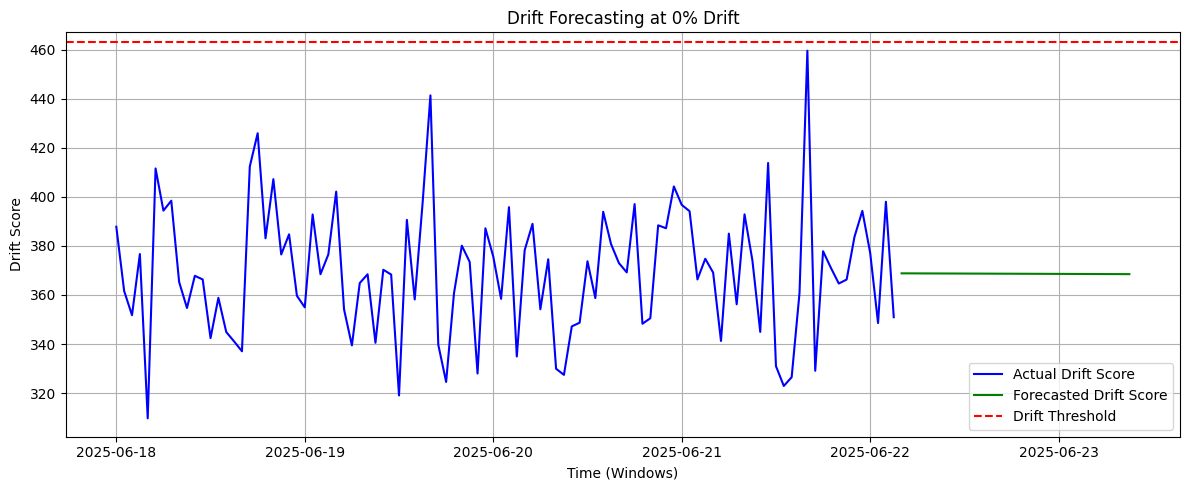

MMD:  1.0
KS:  1.0
LSDD:  0.91
CVM:  1.0
DriftLens:  1.0
 Drift percentage: 5


100%|██████████| 100/100 [02:30<00:00,  1.51s/it]
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqpiztwz/uuyg9ibb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqpiztwz/wdyvp4gz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31710', 'data', 'file=/tmp/tmpyqpiztwz/uuyg9ibb.json', 'init=/tmp/tmpyqpiztwz/wdyvp4gz.json', 'output', 'file=/tmp/tmpyqpiztwz/prophet_modelb2pyg2n4/prophet_model-20250618210256.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:02:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:02:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr

Prophet Forecast Evaluation upto 3.d.p:
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
MAE (drift score): 19.978


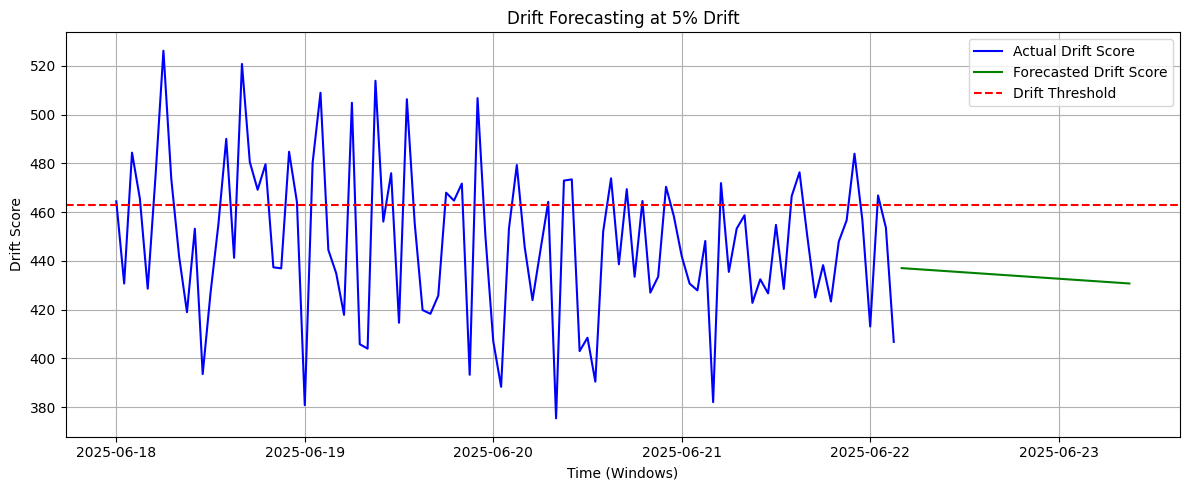

MMD:  0.0
KS:  0.0
LSDD:  0.7
CVM:  0.0
DriftLens:  0.36
 Drift percentage: 10


100%|██████████| 100/100 [02:32<00:00,  1.53s/it]
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqpiztwz/7nqwbm1w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqpiztwz/cu4db6p2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50712', 'data', 'file=/tmp/tmpyqpiztwz/7nqwbm1w.json', 'init=/tmp/tmpyqpiztwz/cu4db6p2.json', 'output', 'file=/tmp/tmpyqpiztwz/prophet_model7kbqisw0/prophet_model-20250618210529.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:05:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:05:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Prophet Forecast Evaluation upto 3.d.p:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
MAE (drift score): 44.858


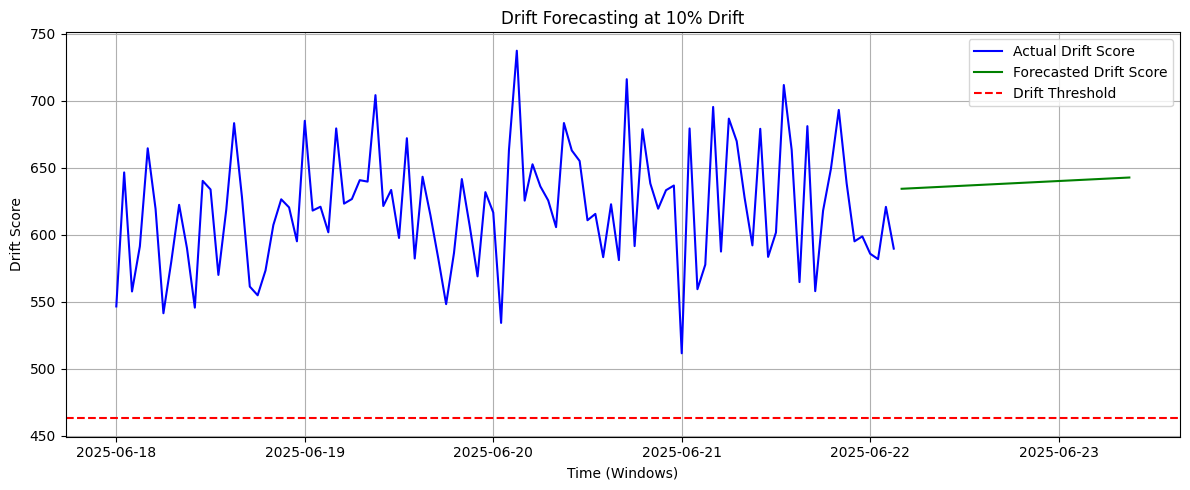

MMD:  0.28
KS:  0.0
LSDD:  0.96
CVM:  0.02
DriftLens:  1.0
 Drift percentage: 15


100%|██████████| 100/100 [02:30<00:00,  1.50s/it]
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqpiztwz/0xjmi8wn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqpiztwz/euth2i3h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11963', 'data', 'file=/tmp/tmpyqpiztwz/0xjmi8wn.json', 'init=/tmp/tmpyqpiztwz/euth2i3h.json', 'output', 'file=/tmp/tmpyqpiztwz/prophet_modelkqumtonj/prophet_model-20250618210800.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:08:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:08:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Prophet Forecast Evaluation upto 3.d.p:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
MAE (drift score): 44.644


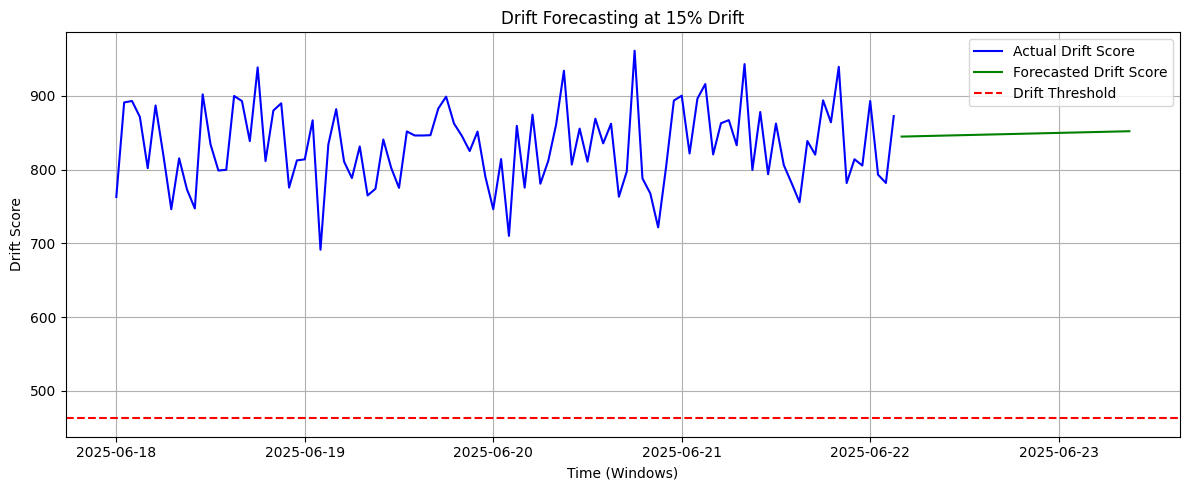

MMD:  0.98
KS:  0.28
LSDD:  1.0
CVM:  0.46
DriftLens:  1.0
 Drift percentage: 20


100%|██████████| 100/100 [02:28<00:00,  1.48s/it]
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqpiztwz/8grbkemh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqpiztwz/2gk47iz7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90162', 'data', 'file=/tmp/tmpyqpiztwz/8grbkemh.json', 'init=/tmp/tmpyqpiztwz/2gk47iz7.json', 'output', 'file=/tmp/tmpyqpiztwz/prophet_modelr_7xc_fy/prophet_model-20250618211028.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:10:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:10:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Prophet Forecast Evaluation upto 3.d.p:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
MAE (drift score): 52.899


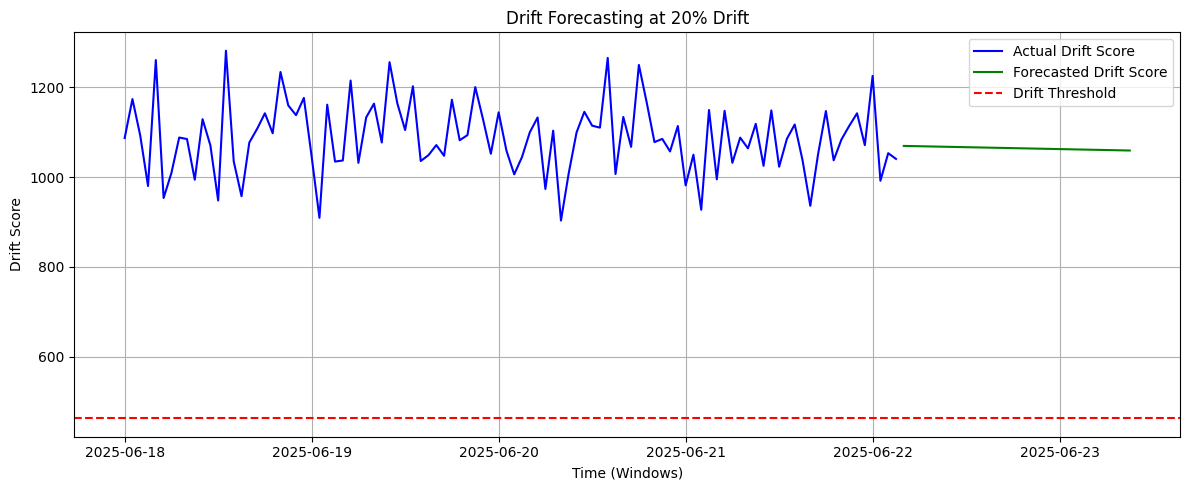

MMD:  1.0
KS:  0.99
LSDD:  1.0
CVM:  1.0
DriftLens:  1.0

Run 2/5
Estimating threshold using frechet_drift_distance metric
Threshold Estimation


100%|██████████| 1000/1000 [04:38<00:00,  3.59it/s]


MMD reference window size: 1000
LSDD reference window size: 1000
CVM reference window size: 1000
KS reference window size: 1000
 Drift percentage: 0


100%|██████████| 100/100 [02:31<00:00,  1.52s/it]
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqpiztwz/6donny9e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqpiztwz/17dr6i7x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95012', 'data', 'file=/tmp/tmpyqpiztwz/6donny9e.json', 'init=/tmp/tmpyqpiztwz/17dr6i7x.json', 'output', 'file=/tmp/tmpyqpiztwz/prophet_modely01wzy9a/prophet_model-20250618211741.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:17:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:17:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr

Prophet Forecast Evaluation upto 3.d.p:
Accuracy: 1.0
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
MAE (drift score): 20.019


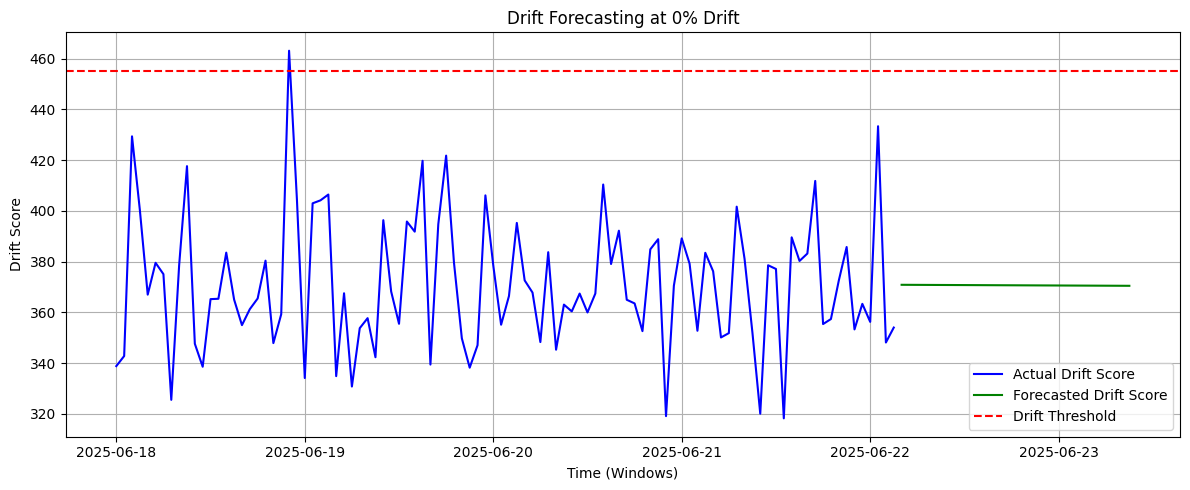

MMD:  1.0
KS:  1.0
LSDD:  0.99
CVM:  1.0
DriftLens:  0.99
 Drift percentage: 5


100%|██████████| 100/100 [02:31<00:00,  1.51s/it]
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqpiztwz/4lj_50jr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqpiztwz/nij3pea2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94029', 'data', 'file=/tmp/tmpyqpiztwz/4lj_50jr.json', 'init=/tmp/tmpyqpiztwz/nij3pea2.json', 'output', 'file=/tmp/tmpyqpiztwz/prophet_model6w_sslum/prophet_model-20250618212013.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:20:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:20:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr

Prophet Forecast Evaluation upto 3.d.p:
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
MAE (drift score): 27.414


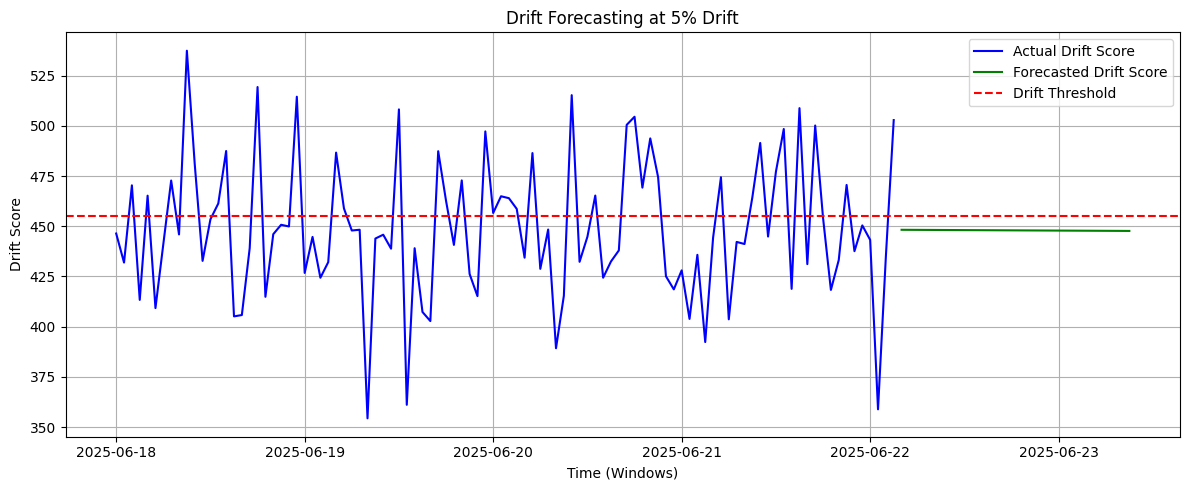

MMD:  0.0
KS:  0.0
LSDD:  0.42
CVM:  0.0
DriftLens:  0.37
 Drift percentage: 10


100%|██████████| 100/100 [02:28<00:00,  1.49s/it]
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqpiztwz/3fdjjwz_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqpiztwz/9gr8ygij.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38818', 'data', 'file=/tmp/tmpyqpiztwz/3fdjjwz_.json', 'init=/tmp/tmpyqpiztwz/9gr8ygij.json', 'output', 'file=/tmp/tmpyqpiztwz/prophet_modelbcw22ucl/prophet_model-20250618212242.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:22:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:22:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Prophet Forecast Evaluation upto 3.d.p:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
MAE (drift score): 32.305


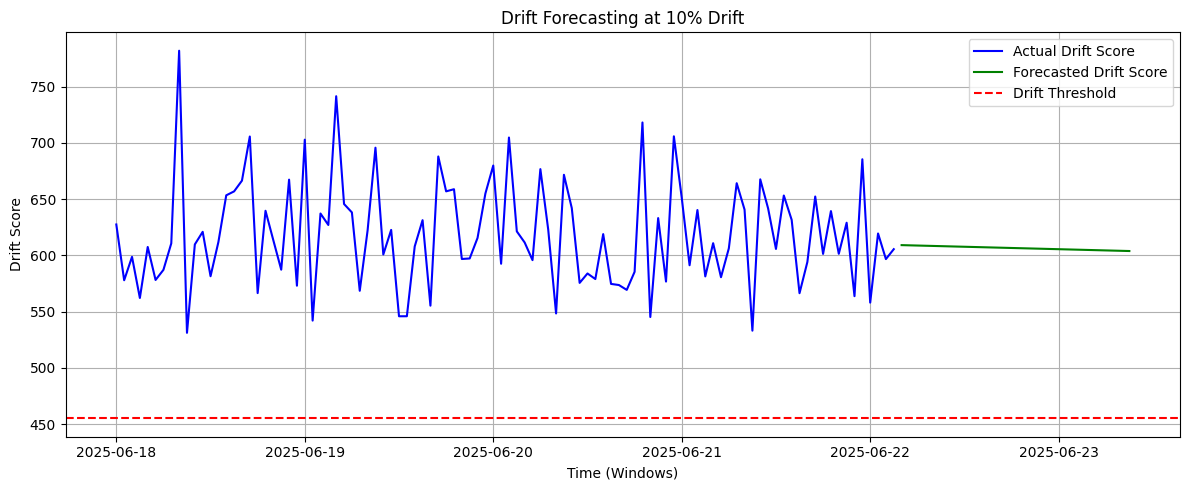

MMD:  0.44
KS:  0.01
LSDD:  0.88
CVM:  0.4
DriftLens:  1.0
 Drift percentage: 15


100%|██████████| 100/100 [02:30<00:00,  1.50s/it]
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqpiztwz/6ud4ogbr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqpiztwz/i6is3m_2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12566', 'data', 'file=/tmp/tmpyqpiztwz/6ud4ogbr.json', 'init=/tmp/tmpyqpiztwz/i6is3m_2.json', 'output', 'file=/tmp/tmpyqpiztwz/prophet_modelfdlx2qeq/prophet_model-20250618212513.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:25:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:25:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Prophet Forecast Evaluation upto 3.d.p:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
MAE (drift score): 44.603


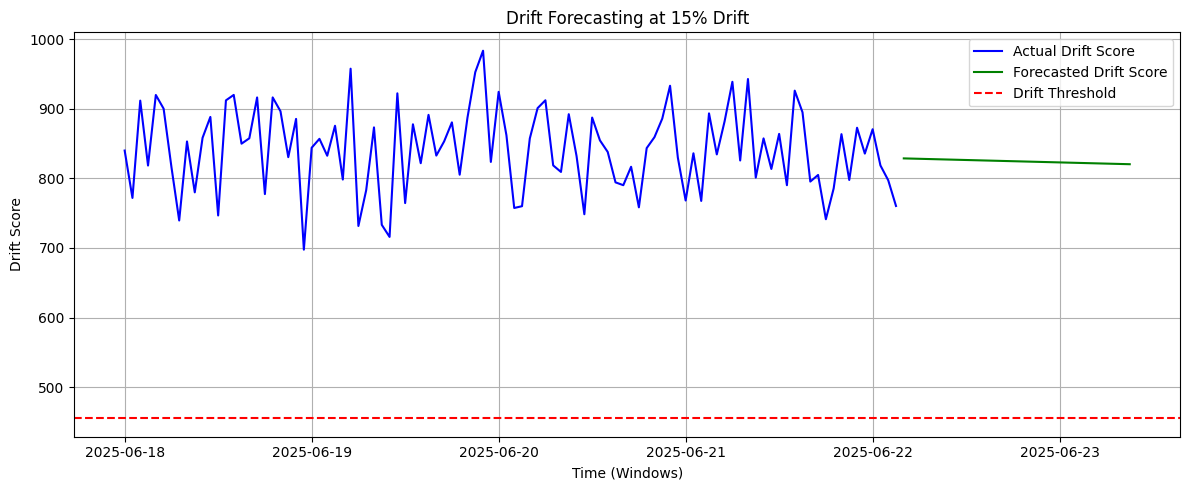

MMD:  1.0
KS:  0.35
LSDD:  1.0
CVM:  0.96
DriftLens:  1.0
 Drift percentage: 20


100%|██████████| 100/100 [02:31<00:00,  1.51s/it]
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqpiztwz/tr7w12e0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqpiztwz/66xux0ir.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43854', 'data', 'file=/tmp/tmpyqpiztwz/tr7w12e0.json', 'init=/tmp/tmpyqpiztwz/66xux0ir.json', 'output', 'file=/tmp/tmpyqpiztwz/prophet_modeli4jl1up5/prophet_model-20250618212744.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:27:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:27:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Prophet Forecast Evaluation upto 3.d.p:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
MAE (drift score): 61.224


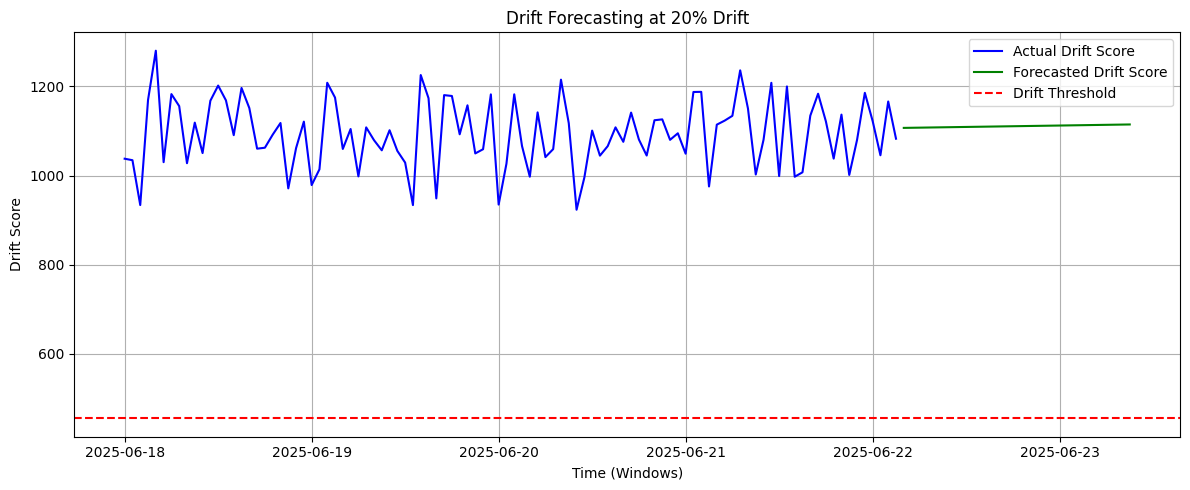

MMD:  1.0
KS:  1.0
LSDD:  1.0
CVM:  1.0
DriftLens:  1.0

Run 3/5
Estimating threshold using frechet_drift_distance metric
Threshold Estimation


100%|██████████| 1000/1000 [04:28<00:00,  3.72it/s]


MMD reference window size: 1000
LSDD reference window size: 1000
CVM reference window size: 1000
KS reference window size: 1000
 Drift percentage: 0


 21%|██        | 21/100 [00:32<02:00,  1.53s/it]


KeyboardInterrupt: 

In [9]:
def load_embedding(filepath, E_name=None, Y_original_name=None, Y_predicted_name=None):
    if filepath is not None:
        with h5py.File(filepath, "r") as hf:
            if E_name is None:
                E = hf["E"][()]
            else:
                E = hf[E_name][()]
            if Y_original_name is None:
                Y_original = hf["Y_original"][()]
            else:
                Y_original = hf[Y_original_name][()]
            if Y_predicted_name is None:
                Y_predicted = hf["Y_predicted"][()]
            else:
                Y_predicted = hf[Y_predicted_name][()]
    else:
        raise Exception("Error in loading the embedding file. Please set the embedding paths in the configuration file.")
    return E, Y_original, Y_predicted


def stratified_subsampling(E, Y, n_samples, unique_labels):
    # Calculate samples per class
    samples_per_class = int(n_samples / len(unique_labels))

    # Placeholder for stratified sample indices
    selected_indices = []

    for label in unique_labels:
        # Find indices where current label occurs
        label_indices = np.where(Y == label)[0]

        # If the class has fewer samples than samples_per_class, take them all
        # Otherwise, randomly choose samples_per_class from them
        if len(label_indices) <= samples_per_class:
            selected_indices.extend(label_indices)
        else:
            selected_indices.extend(np.random.choice(label_indices, samples_per_class, replace=False))

    # Now, selected_indices contains the indices of the stratified sample
    # Extract the corresponding elements from E
    E_subsample = E[selected_indices]

    return E_subsample, Y[selected_indices]


def main():
    print("Drift Detection Experiment - Use Case - Fashion MNIST")

    # Parse arguments
    args = parse_args()

    print("Model name: ", args.model_name)
    print("Number of runs: ", args.number_of_runs)
    print("Window size: ", args.window_size)
    print("Number of windows: ", args.number_of_windows)
    print("Number of window reference samples : ", args.n_subsamples_mmd)
    print("Number of window reference samples : ", args.n_subsamples_lsdd)
    print("Number of window reference samples : ", args.n_subsamples_cvm)
    print("Number of window reference samples : ", args.n_subsamples_ks)
    print("Number of samples threshold: ", args.threshold_number_of_estimation_samples)
    print("Drift percentage: ", args.drift_percentage)

    training_label_list = [0, 1, 2, 3, 4, 5, 6, 7]  # Labels used for training
    drift_label_list = [8]  # Labels used for drift simulation

    if args.save_results:
        if not os.path.exists(args.output_dir):
            os.makedirs(args.output_dir)
        ts = time.time()
        timestamp = str(datetime.datetime.fromtimestamp(ts).strftime('%Y%m%d_%H%M%S'))
        output_filename = f"drift_detection_accuracy_model_{args.model_name}_win_size_{args.window_size}_n_windows_{args.number_of_windows}_{timestamp}.json"

    # Parse parameters
    window_size = args.window_size
    batch_n_pc = args.batch_n_pc
    per_label_n_pc = args.per_label_n_pc
    n_windows = args.number_of_windows

    # Load the embeddings
    if args.model_name == "vgg16":
        #E_train, Y_original_train, Y_predicted_train = load_embedding(args.train_embedding_filepath, E_name="E", Y_original_name="original_label", Y_predicted_name="predicted_label")
        #E_test, Y_original_test, Y_predicted_test = load_embedding(args.test_embedding_filepath, E_name="E", Y_original_name="original_label", Y_predicted_name="predicted_label")
        #E_new_unseen, Y_original_new_unseen, Y_predicted_new_unseen = load_embedding(args.new_unseen_embedding_filepath, E_name="E", Y_original_name="original_label", Y_predicted_name="predicted_label")
        #E_drift, Y_original_drift, Y_predicted_drift = load_embedding(args.drift_embedding_filepath, E_name="E", Y_original_name="original_label", Y_predicted_name="predicted_label")
        E_train, Y_original_train, Y_predicted_train = load_embedding(args.train_embedding_filepath)
        E_test, Y_original_test, Y_predicted_test = load_embedding(args.test_embedding_filepath)
        E_new_unseen, Y_original_new_unseen, Y_predicted_new_unseen = load_embedding(args.new_unseen_embedding_filepath)
        E_drift, Y_original_drift, Y_predicted_drift = load_embedding(args.drift_embedding_filepath)

        E_train = E_train.reshape(E_train.shape[0], -1)
        E_test = E_test.reshape(E_test.shape[0], -1)
        E_new_unseen = E_new_unseen.reshape(E_new_unseen.shape[0], -1)
        E_drift = E_drift.reshape(E_drift.shape[0], -1)

    else:
        E_train, Y_original_train, Y_predicted_train = load_embedding(args.train_embedding_filepath)
        E_test, Y_original_test, Y_predicted_test = load_embedding(args.test_embedding_filepath)
        E_new_unseen, Y_original_new_unseen, Y_predicted_new_unseen = load_embedding(args.new_unseen_embedding_filepath)
        E_drift, Y_original_drift, Y_predicted_drift = load_embedding(args.drift_embedding_filepath)

    print("Input shape", E_train.shape)

    print("Training samples:", len(E_train))
    print("Test samples:", len(E_test))
    print("New unseen samples:", len(E_new_unseen))
    print("Drift samples:", len(E_drift))


    ks_acc_dict = {str(p): [] for p in args.drift_percentage}
    mmd_acc_dict = {str(p): [] for p in args.drift_percentage}
    lsdd_acc_dict = {str(p): [] for p in args.drift_percentage}
    cvm_acc_dict = {str(p): [] for p in args.drift_percentage}
    driftlens_acc_dict = {str(p): [] for p in args.drift_percentage}

    output_dict_run_list = []

    output_dict = {"params": vars(args)}

    for run_id in range(args.number_of_runs):

        print(f"\nRun {run_id + 1}/{args.number_of_runs}")

        # Initialize the WindowsGenerator - used for creating the windows
        wg = WindowsGenerator(training_label_list,
                              drift_label_list,
                              E_new_unseen,
                              Y_predicted_new_unseen,
                              Y_original_new_unseen,
                              E_drift,
                              Y_predicted_drift,
                              Y_original_drift)

        if args.run_driftlens:
            # Initialize the DriftLens
            dl = DriftLens()

            # Estimate the baseline with DriftLens
            baseline = dl.estimate_baseline(E=E_train,
                                            Y=Y_predicted_train,
                                            label_list=training_label_list,
                                            batch_n_pc=batch_n_pc,
                                            per_label_n_pc=per_label_n_pc)

            # Estimate the threshold values with DriftLens
            per_batch_distances_sorted, per_label_distances_sorted = dl.random_sampling_threshold_estimation(
                label_list=training_label_list,
                E=E_test,
                Y=Y_predicted_test,
                batch_n_pc=batch_n_pc,
                per_label_n_pc=per_label_n_pc,
                window_size=window_size,
                n_samples=args.threshold_number_of_estimation_samples,
                flag_shuffle=True,
                flag_replacement=True)

            # Calculate the threshold values
            l = np.array(per_batch_distances_sorted)
            l = l[(l > np.quantile(l, 0.01)) & (l < np.quantile(l, 0.99))].tolist()
            per_batch_th = max(l)
        else:
            print("DriftLens skipped")

        if (args.n_subsamples_mmd < len(E_train)) and (args.n_subsamples_mmd != -1):

            E_subsample_mmd, Y_subsample_mmd = stratified_subsampling(E_train,
                                                              Y_original_train,
                                                              n_samples=args.n_subsamples_mmd,
                                                              unique_labels=training_label_list)
        else:
            E_subsample_mmd, Y_subsample_mmd = (E_train, Y_original_train)

        if (args.n_subsamples_lsdd < len(E_train)) and (args.n_subsamples_lsdd != -1):

            E_subsample_lsdd, Y_subsample_lsdd = stratified_subsampling(E_train,
                                                              Y_original_train,
                                                              n_samples=args.n_subsamples_lsdd,
                                                              unique_labels=training_label_list)
        else:
            E_subsample_lsdd, Y_subsample_lsdd = (E_train, Y_original_train)

        if (args.n_subsamples_cvm < len(E_train)) and (args.n_subsamples_cvm != -1):

            E_subsample_cvm, Y_subsample_cvm = stratified_subsampling(E_train,
                                                              Y_original_train,
                                                              n_samples=args.n_subsamples_cvm,
                                                              unique_labels=training_label_list)
        else:
            E_subsample_cvm, Y_subsample_cvm = (E_train, Y_original_train)

        if (args.n_subsamples_ks < len(E_train)) and (args.n_subsamples_ks != -1):

            E_subsample_ks, Y_subsample_ks = stratified_subsampling(E_train,
                                                              Y_original_train,
                                                              n_samples=args.n_subsamples_ks,
                                                              unique_labels=training_label_list)
        else:
            E_subsample_ks = E_train
            Y_subsample_ks = Y_original_train

        print(f"MMD reference window size: {E_subsample_mmd.shape[0]}")
        print(f"LSDD reference window size: {E_subsample_lsdd.shape[0]}")
        print(f"CVM reference window size: {E_subsample_cvm.shape[0]}")
        print(f"KS reference window size: {E_subsample_ks.shape[0]}")

        # Initialize drift detectors used for comparison
        ks_detector = KSDrift(E_subsample_ks, p_val=.05)
        mmd_detector = MMDDrift(E_subsample_mmd, p_val=.05, n_permutations=100, backend="pytorch")
        lsdd_detector = LSDDDrift(E_subsample_lsdd, backend='pytorch', p_val=.05)
        cvm_detector = CVMDrift(E_subsample_cvm, p_val=.05)

        for current_drift_percentage in args.drift_percentage:

            print(f" Drift percentage: {current_drift_percentage}")

            # Initialize empty lists of predictions
            ks_preds = []
            mmd_preds = []
            lsdd_preds = []
            cvm_preds = []
            dl_distances = []

            # Ground truth
            if current_drift_percentage > 0:
                ground_truth = [1] * n_windows
            else:
                ground_truth = [0] * n_windows

            # Generate windows and predict drift
            for i in tqdm(range(n_windows)):

                if current_drift_percentage > 0:
                    # Drift
                    E_windows, Y_predicted_windows, Y_original_windows = wg.balanced_constant_drift_windows_generation(window_size=window_size,
                                                                                                                        n_windows=1,
                                                                                                                        drift_percentage=float(current_drift_percentage/100),
                                                                                                                        flag_shuffle=True,
                                                                                                                        flag_replacement=True)

                else:
                    # No Drift
                    E_windows, Y_predicted_windows, Y_original_windows = wg.balanced_without_drift_windows_generation(window_size=window_size,
                                                                                                                      n_windows=1,
                                                                                                                      flag_shuffle=True,
                                                                                                                      flag_replacement=True)

                for w_id in range(len(E_windows)):
                    E_windows[w_id] = np.float32(E_windows[w_id])

                if args.run_driftlens:
                    # Compute the window distribution distances (Frechet Inception Distance) with DriftLens
                    dl_distance = dl.compute_window_distribution_distances(E_windows[0], Y_predicted_windows[0])

                # Predict drift with the drift detectors used for comparison
                ks_pred = ks_detector.predict(E_windows[0])
                mmd_pred = mmd_detector.predict(E_windows[0])
                lsdd_pred = lsdd_detector.predict(E_windows[0], return_p_val=True, return_distance=True)
                cvm_pred = cvm_detector.predict(E_windows[0], drift_type='batch', return_p_val=True, return_distance=True)

                # Append the predictions to the lists
                ks_preds.append(ks_pred["data"]["is_drift"])
                mmd_preds.append(mmd_pred["data"]["is_drift"])
                lsdd_preds.append(lsdd_pred["data"]["is_drift"])
                cvm_preds.append(cvm_pred["data"]["is_drift"])

                if args.run_driftlens:
                    dl_distances.append(dl_distance)

            if args.run_driftlens:
                dl_preds = []
                for dl_distance in dl_distances:
                    if dl_distance["per-batch"] > per_batch_th:
                        dl_preds.append(1)
                    else:
                        dl_preds.append(0)

            # Savig drift distances per window
            forecast_horizon = 30
            drift_scores = [d["per-batch"] for d in dl_distances]
            timestamps = pd.date_range(start='2025-06-18', periods=len(drift_scores), freq='h') # hourly forecast "H"

            df_prophet = pd.DataFrame({
                'ds': timestamps,
                'y': drift_scores
            })

            scaler = MinMaxScaler()
            df_prophet['y'] = scaler.fit_transform(df_prophet[['y']])

            # model = Prophet()
            model = Prophet(
              daily_seasonality=False,
              weekly_seasonality=False,
              yearly_seasonality=False,
              seasonality_mode='additive',
              seasonality_prior_scale=0.01
            )
            model.fit(df_prophet)

            # start forecasting next 30 windows @hourly
            future = model.make_future_dataframe(periods=forecast_horizon, freq='h')
            forecast = model.predict(future)

            # predicted scores
            forecast_scaled = forecast['yhat'][-forecast_horizon:].values.reshape(-1, 1)
            forecast_scores = scaler.inverse_transform(forecast_scaled).flatten()
            # forecast_scores = forecast['yhat'][-n_windows:].values

            # binarize predictions using drift threshold so that we can utilize traditional evaluation metrics
            scaled_th = scaler.transform([[per_batch_th]])[0][0]
            forecasted_labels = [1 if y > scaled_th else 0 for y in forecast['yhat'][-forecast_horizon:]]

            # forecasted_labels = [1 if y > per_batch_th else 0 for y in forecast_scores]

            # use alr set ground truth labels
            true_labels = ground_truth[-forecast_horizon:]

            # evaluate forecast performance
            acc = accuracy_score(true_labels, forecasted_labels)
            prec = precision_score(true_labels, forecasted_labels)
            rec = recall_score(true_labels, forecasted_labels)
            f1 = f1_score(true_labels, forecasted_labels)
            mae = mean_absolute_error(drift_scores[-forecast_horizon:], forecast_scores)

            print("Prophet Forecast Evaluation upto 3.d.p:")
            print("Accuracy:", round(acc, 3))
            print("Precision:", round(prec, 3))
            print("Recall:", round(rec, 3))
            print("F1 Score:", round(f1, 3))
            print("MAE (drift score):", round(mae, 3))

            forecast_timestamps = pd.date_range(start=timestamps[-1] + pd.Timedelta(hours=1), periods=forecast_horizon, freq='h')

            plt.figure(figsize=(12, 5))
            plt.plot(timestamps, drift_scores, label='Actual Drift Score', color='blue')
            plt.plot(forecast_timestamps, forecast_scores, label='Forecasted Drift Score', color='green')
            plt.axhline(per_batch_th, color='red', linestyle='--', label='Drift Threshold')
            plt.title(f"Drift Forecasting at {current_drift_percentage}% Drift")
            plt.xlabel("Time (Windows)")
            plt.ylabel("Drift Score")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

            # # forecast vs actual plot
            # plt.figure(figsize=(12, 5))
            # plt.plot(timestamps, drift_scores, label='Actual Drift Score')
            # plt.plot(timestamps, forecast_scores, label='Forecasted Drift Score')
            # plt.axhline(per_batch_th, color='red', linestyle='--', label='Drift Threshold')
            # plt.title(f"Drift Forecasting at {current_drift_percentage}% Drift")
            # plt.xlabel("Time (Windows)")
            # plt.ylabel("Drift Score")
            # plt.legend()
            # plt.grid(True)
            # plt.tight_layout()
            # plt.show()

            # Calculate the accuracy of the drift detectors
            ks_acc = accuracy_score(ground_truth, ks_preds, normalize=True)
            mmd_acc = accuracy_score(ground_truth, mmd_preds, normalize=True)
            lsdd_acc = accuracy_score(ground_truth, lsdd_preds, normalize=True)
            cvm_acc = accuracy_score(ground_truth, cvm_preds, normalize=True)
            if args.run_driftlens:
                driftlens_acc = accuracy_score(ground_truth, dl_preds, normalize=True)
            else:
                driftlens_acc = -1

            ks_acc_dict[str(current_drift_percentage)].append(ks_acc)
            mmd_acc_dict[str(current_drift_percentage)].append(mmd_acc)
            lsdd_acc_dict[str(current_drift_percentage)].append(lsdd_acc)
            cvm_acc_dict[str(current_drift_percentage)].append(cvm_acc)
            driftlens_acc_dict[str(current_drift_percentage)].append(driftlens_acc)

            print("MMD: ", mmd_acc)
            print("KS: ", ks_acc)
            print("LSDD: ", lsdd_acc)
            print("CVM: ", cvm_acc)
            print("DriftLens: ", driftlens_acc)

            # Create the output dictionary
            output_dict_run = {f"run_id":run_id, "drift_percentage": current_drift_percentage, "KS": ks_acc, "MMD": mmd_acc, "LSDD": lsdd_acc, "CVM": cvm_acc, "DriftLens": driftlens_acc}
            output_dict_run_list.append(output_dict_run)

              # save output log
            output_dict_run.update({
                "Prophet": {
                    "Accuracy": float(acc),
                    "Precision": float(prec),
                    "Recall": float(rec),
                    "F1": float(f1),
                    "MAE": float(mae)
                }
            })

    output_dict["runs_log"] = output_dict_run_list

    for p in args.drift_percentage:
        output_dict[str(p)] = {"accuracy_list": {"KS": ks_acc_dict[str(p)], "MMD": mmd_acc_dict[str(p)], "LSDD": lsdd_acc_dict[str(p)], "CVM": cvm_acc_dict[str(p)], "DriftLens": driftlens_acc_dict[str(p)]},
                                  "mean_accuracy": {"KS": np.mean(ks_acc_dict[str(p)]), "MMD": np.mean(mmd_acc_dict[str(p)]), "LSDD": np.mean(lsdd_acc_dict[str(p)]), "CVM": np.mean(cvm_acc_dict[str(p)]), "DriftLens": np.mean(driftlens_acc_dict[str(p)])},
                                  "standard_deviation_accuracy": {"KS": np.std(ks_acc_dict[str(p)]), "MMD": np.std(mmd_acc_dict[str(p)]), "LSDD": np.std(lsdd_acc_dict[str(p)]), "CVM": np.std(cvm_acc_dict[str(p)]), "DriftLens": np.std(driftlens_acc_dict[str(p)])}}

    mean_accuracy_drift_list_mmd = []
    mean_accuracy_drift_list_ks = []
    mean_accuracy_drift_list_lsdd = []
    mean_accuracy_drift_list_cvm = []
    mean_accuracy_drift_list_driftlens = []
    for p in args.drift_percentage:
        if p > 0:
            mean_accuracy_drift_list_mmd.append(output_dict[str(p)]["mean_accuracy"]["MMD"])
            mean_accuracy_drift_list_ks.append(output_dict[str(p)]["mean_accuracy"]["KS"])
            mean_accuracy_drift_list_lsdd.append(output_dict[str(p)]["mean_accuracy"]["LSDD"])
            mean_accuracy_drift_list_cvm.append(output_dict[str(p)]["mean_accuracy"]["CVM"])
            mean_accuracy_drift_list_driftlens.append(output_dict[str(p)]["mean_accuracy"]["DriftLens"])

    hdd_mmd = statistics.harmonic_mean([output_dict['0']["mean_accuracy"]["MMD"], np.mean(mean_accuracy_drift_list_mmd)])
    hdd_ks = statistics.harmonic_mean([output_dict['0']["mean_accuracy"]["KS"], np.mean(mean_accuracy_drift_list_ks)])
    hdd_lsdd = statistics.harmonic_mean([output_dict['0']["mean_accuracy"]["LSDD"], np.mean(mean_accuracy_drift_list_lsdd)])
    hdd_cvm = statistics.harmonic_mean([output_dict['0']["mean_accuracy"]["CVM"], np.mean(mean_accuracy_drift_list_cvm)])
    if args.run_driftlens:
        hdd_driftlens = statistics.harmonic_mean(
            [output_dict['0']["mean_accuracy"]["DriftLens"], np.mean(mean_accuracy_drift_list_driftlens)])
    else:
        hdd_driftlens = -1


    output_dict["HDD"] = {"MMD": hdd_mmd, "KS": hdd_ks, "LSDD": hdd_lsdd, "CVM": hdd_cvm, "DriftLens": hdd_driftlens}
    # Save the output dictionary
    with open(os.path.join(args.output_dir, output_filename), 'w') as fp:
        json.dump(output_dict, fp)

    return


if __name__ == "__main__":
    main()